# Time Series Linear Regression Algorithm

This algorithm is used to forecast FOREX prices for the USDJPY pair. It fetches data from MetaTrader5 and applies feature engineering to create additional data.

The forecasted values are set to:
- **Position 1** if the prediction indicates that the price will go up in the next hour
- **Position 0** if the prediction indicates that the price will go down in the nex hour


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-darkgrid")
from matplotlib import cycler
import warnings
warnings.filterwarnings("ignore")
import ta
import seaborn as sns
import MetaTrader5 as mt5
from datetime import datetime
from UsefulFunctions import data, backtest

In [3]:
# Initiate bound between MetaTrader5 and Python
mt5.initialize()

True

In [4]:
# Fetching data from MetaTrader5 from 2015 to the present using the custom function "get_rates" from the data.py file
# The historical data retrieved is of 1-hour timeframe
df = data.get_rates("USDJPY", mt5.TIMEFRAME_H1, datetime(2015,1,1))
df

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2015-01-02 08:00:00,120.420,120.440,120.330,120.390,262,30,0
2015-01-02 09:00:00,120.400,120.500,120.380,120.430,599,30,0
2015-01-02 10:00:00,120.440,120.480,120.340,120.340,832,30,0
2015-01-02 11:00:00,120.330,120.420,120.310,120.400,761,30,0
2015-01-02 12:00:00,120.410,120.470,120.370,120.430,484,30,0
...,...,...,...,...,...,...,...
2024-08-13 13:00:00,147.884,147.909,147.526,147.526,3584,18,0
2024-08-13 14:00:00,147.525,147.603,147.304,147.341,4006,18,0
2024-08-13 15:00:00,147.342,147.502,147.025,147.397,6254,17,0


In [5]:
# Create a copy of the original DataFrame and reduce it to close values only for feature engineering
df_copy = df.copy()
df_copy = df_copy[["close"]]
df_copy

,close
time,
2015-01-02 08:00:00,120.390
2015-01-02 09:00:00,120.430
2015-01-02 10:00:00,120.340
2015-01-02 11:00:00,120.400
2015-01-02 12:00:00,120.430
...,...
2024-08-13 13:00:00,147.526
2024-08-13 14:00:00,147.341
2024-08-13 15:00:00,147.397


In [6]:
# Here I added a new column with the percent change between the close price and the previous close price
df_copy["pct_change"] = df_copy["close"].pct_change(1)
df_copy

,close,pct_change
time,,
2015-01-02 08:00:00,120.390,NaN
2015-01-02 09:00:00,120.430,0.000332
2015-01-02 10:00:00,120.340,-0.000747
2015-01-02 11:00:00,120.400,0.000499
2015-01-02 12:00:00,120.430,0.000249
...,...,...
2024-08-13 13:00:00,147.526,-0.002421
2024-08-13 14:00:00,147.341,-0.001254
2024-08-13 15:00:00,147.397,0.000380


## In the next section I started working on feature engineering and added more technical indicators

In [8]:
# Here were added columns with shifted values of the pct_change column
# The function "add_shifted_columns" was added to the data.py file 

df_copy = data.add_shifted_columns(df_copy,4, "pct_change")
df_copy

,close,pct_change,1_pct_change_bars_ago,2_pct_change_bars_ago,3_pct_change_bars_ago,4_pct_change_bars_ago
time,,,,,,
2015-01-02 08:00:00,120.390,NaN,NaN,NaN,NaN,NaN
2015-01-02 09:00:00,120.430,0.000332,NaN,NaN,NaN,NaN
2015-01-02 10:00:00,120.340,-0.000747,0.000332,NaN,NaN,NaN
2015-01-02 11:00:00,120.400,0.000499,-0.000747,0.000332,NaN,NaN
2015-01-02 12:00:00,120.430,0.000249,0.000499,-0.000747,0.000332,NaN
...,...,...,...,...,...,...
2024-08-13 13:00:00,147.526,-0.002421,0.000331,-0.000101,-0.000169,0.001565
2024-08-13 14:00:00,147.341,-0.001254,-0.002421,0.000331,-0.000101,-0.000169
2024-08-13 15:00:00,147.397,0.000380,-0.001254,-0.002421,0.000331,-0.000101


In [9]:
# A Simple Moving Average indicator was created and shifted one row so the outcome value of the previous time stamp
# make sence to predict the current value

df_copy["SMA 7"] = df_copy["close"].rolling(7).mean().shift(1)
df_copy.head(10)

,close,pct_change,1_pct_change_bars_ago,2_pct_change_bars_ago,3_pct_change_bars_ago,4_pct_change_bars_ago,SMA 7
time,,,,,,,
2015-01-02 08:00:00,120.39,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02 09:00:00,120.43,0.000332,NaN,NaN,NaN,NaN,NaN
2015-01-02 10:00:00,120.34,-0.000747,0.000332,NaN,NaN,NaN,NaN
2015-01-02 11:00:00,120.40,0.000499,-0.000747,0.000332,NaN,NaN,NaN
2015-01-02 12:00:00,120.43,0.000249,0.000499,-0.000747,0.000332,NaN,NaN
2015-01-02 13:00:00,120.47,0.000332,0.000249,0.000499,-0.000747,0.000332,NaN
2015-01-02 14:00:00,120.62,0.001245,0.000332,0.000249,0.000499,-0.000747,NaN
2015-01-02 15:00:00,120.60,-0.000166,0.001245,0.000332,0.000249,0.000499,120.440000
2015-01-02 16:00:00,120.68,0.000663,-0.000166,0.001245,0.000332,0.000249,120.470000


In [10]:
# Here we are adding more technical indicators and delete the NaN values
df_copy["SMA 21"] = df_copy["close"].rolling(21).mean().shift(1)
df_copy["STD 10"] = df_copy["close"].rolling(10).std().shift(1)
df_copy["STD 30"] = df_copy["close"].rolling(30).std().shift(1)

RSI = ta.momentum.RSIIndicator(df["close"], window=21, fillna=False)
df_copy["RSI 21"] = RSI.rsi().shift(1)

df_copy.dropna(inplace=True)
df_copy.head()

,close,pct_change,1_pct_change_bars_ago,2_pct_change_bars_ago,3_pct_change_bars_ago,4_pct_change_bars_ago,SMA 7,SMA 21,STD 10,STD 30,RSI 21
time,,,,,,,,,,,
2015-01-05 14:00:00,120.15,-0.000915,-0.000748,0.001165,-0.001163,-0.000083,120.328571,120.356667,0.114819,0.128298,45.686998
2015-01-05 15:00:00,119.82,-0.002747,-0.000915,-0.000748,0.001165,-0.001163,120.294286,120.354762,0.134726,0.135879,42.432619
2015-01-05 16:00:00,119.48,-0.002838,-0.002747,-0.000915,-0.000748,0.001165,120.214286,120.336667,0.194276,0.170463,34.656383
2015-01-05 17:00:00,119.58,0.000837,-0.002838,-0.002747,-0.000915,-0.000748,120.088571,120.300952,0.298487,0.235143,28.922381
2015-01-05 18:00:00,119.64,0.000502,0.000837,-0.002838,-0.002747,-0.000915,119.978571,120.266667,0.340594,0.272396,32.377600


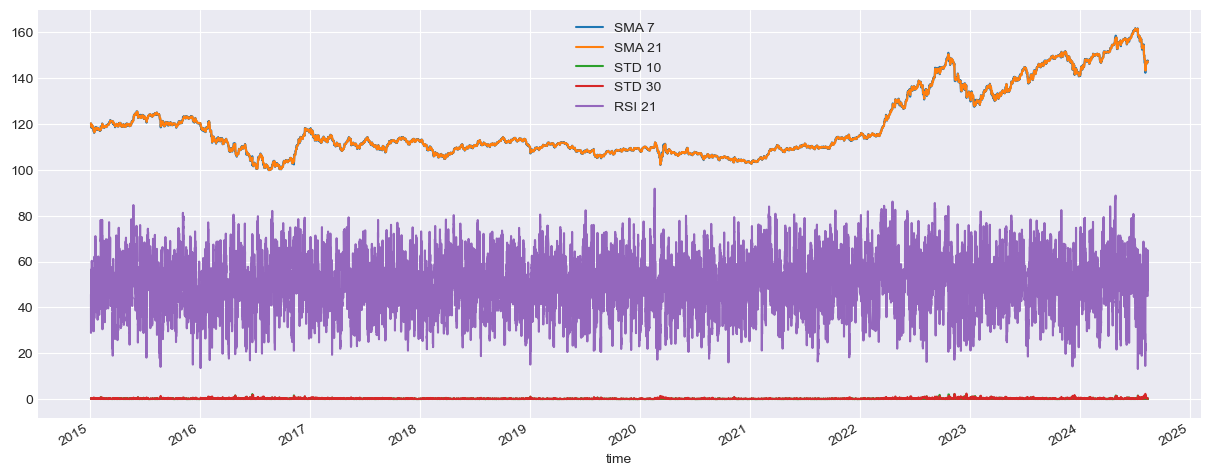

In [11]:
# Plotting the values for the indicators: SMA 7, SMA 21, STD 10, STD 30, and RSI
df_copy[["SMA 7", "SMA 21", "STD 10", "STD 30", "RSI 21"]].plot(figsize=(15, 6));

# Machine Learning Section

In [13]:
# Splitting the data into features, labels, train and test sets
split = int(0.80 * len(df_copy))

X = df_copy.iloc[:,2:]
y = df_copy["pct_change"]

X_train = X.iloc[:split]
y_train = y.iloc[:split]

X_test = X.iloc[split:]
y_test = y.iloc[split:]

In [14]:
# Here, the data is being standardized so all features have a similar scale, ensuring balanced weights in the ML model
from sklearn.preprocessing import StandardScaler

# Only the feature set (X) needs to be standardized, not the targets (labels)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

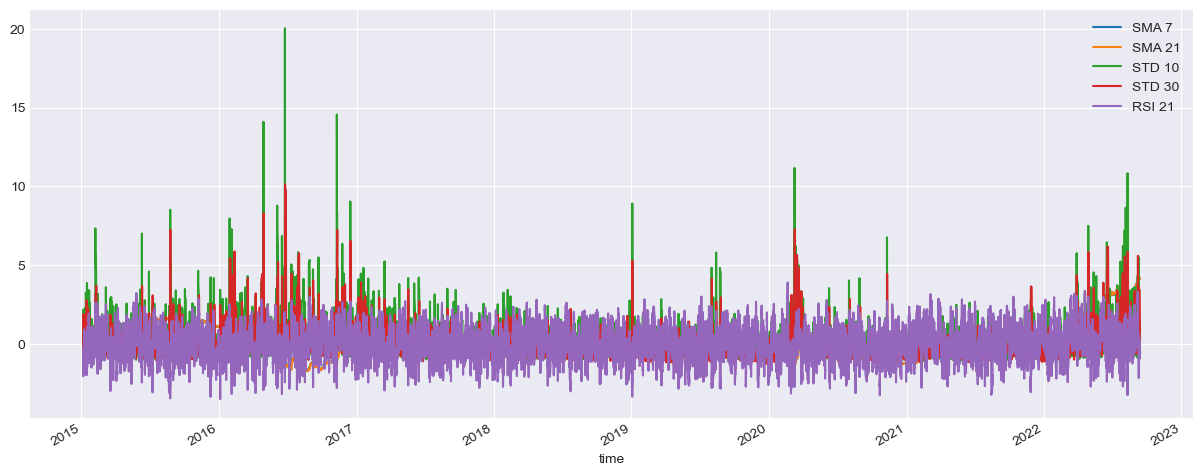

In [15]:
# Plotting the standardized data for the indicators
pd.DataFrame(X_train_scaled, index=X_train.index, columns=X.columns).iloc[:,4:].plot(figsize=(15, 6));

## Training the Model and Making Predictions

In [17]:
from sklearn.linear_model import LinearRegression

In [18]:
regressor = LinearRegression()

# Training the model
regressor.fit(X_train_scaled, y_train)

# Making predictions
predictions = regressor.predict(X_test_scaled)

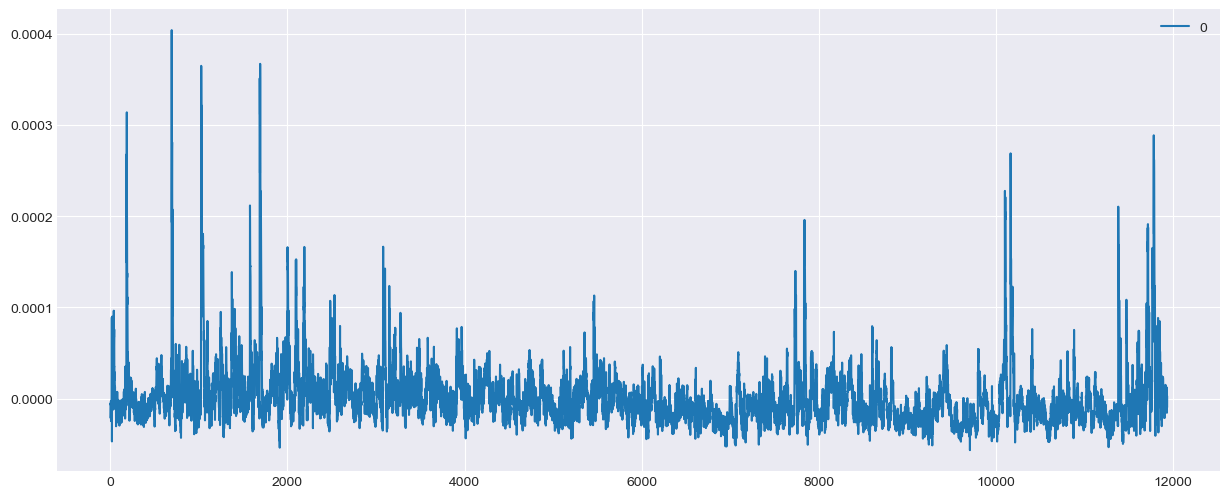

In [19]:
# Plotting to visualize predictions going in both directions
pd.DataFrame(predictions).plot(figsize=(15,6));

In [20]:
predictions.shape

(11935,)

In [21]:
# Here I created a new DataFrame with the percent change which are the labels and the predictions made by the model
df_with_outcomes = df_copy[["pct_change"]].iloc[split:]
df_with_outcomes["prediction"] = predictions
df_with_outcomes

,pct_change,prediction
time,,
2022-09-12 23:00:00,0.000028,-0.000021
2022-09-13 00:00:00,-0.000147,-0.000018
2022-09-13 01:00:00,-0.000553,-0.000009
2022-09-13 02:00:00,-0.001009,-0.000005
2022-09-13 03:00:00,-0.000940,-0.000007
...,...,...
2024-08-13 13:00:00,-0.002421,0.000005
2024-08-13 14:00:00,-0.001254,-0.000015
2024-08-13 15:00:00,0.000380,-0.000002


In [22]:
# 2 new columns where added, creating the predictions directions for both real and predicted values 
# So can be compared and find accuracy
df_with_outcomes["real_position"] = np.sign(df_with_outcomes["pct_change"])
df_with_outcomes["pred_position"] = np.sign(df_with_outcomes["prediction"])
df_with_outcomes

,pct_change,prediction,real_position,pred_position
time,,,,
2022-09-12 23:00:00,0.000028,-0.000021,1.0,-1.0
2022-09-13 00:00:00,-0.000147,-0.000018,-1.0,-1.0
2022-09-13 01:00:00,-0.000553,-0.000009,-1.0,-1.0
2022-09-13 02:00:00,-0.001009,-0.000005,-1.0,-1.0
2022-09-13 03:00:00,-0.000940,-0.000007,-1.0,-1.0
...,...,...,...,...
2024-08-13 13:00:00,-0.002421,0.000005,-1.0,1.0
2024-08-13 14:00:00,-0.001254,-0.000015,-1.0,-1.0
2024-08-13 15:00:00,0.000380,-0.000002,1.0,-1.0


In [23]:
# Calculating the returns by multiplying real percent change and forecasted positions
# Predictions are not shifted by one since all feature were already shifted one row. Predictions are already made with previous bar's data
df_with_outcomes["returns"] = df_with_outcomes["pct_change"] * df_with_outcomes["pred_position"]
df_with_outcomes.head()

,pct_change,prediction,real_position,pred_position,returns
time,,,,,
2022-09-12 23:00:00,0.000028,-0.000021,1.0,-1.0,-0.000028
2022-09-13 00:00:00,-0.000147,-0.000018,-1.0,-1.0,0.000147
2022-09-13 01:00:00,-0.000553,-0.000009,-1.0,-1.0,0.000553
2022-09-13 02:00:00,-0.001009,-0.000005,-1.0,-1.0,0.001009
2022-09-13 03:00:00,-0.000940,-0.000007,-1.0,-1.0,0.000940


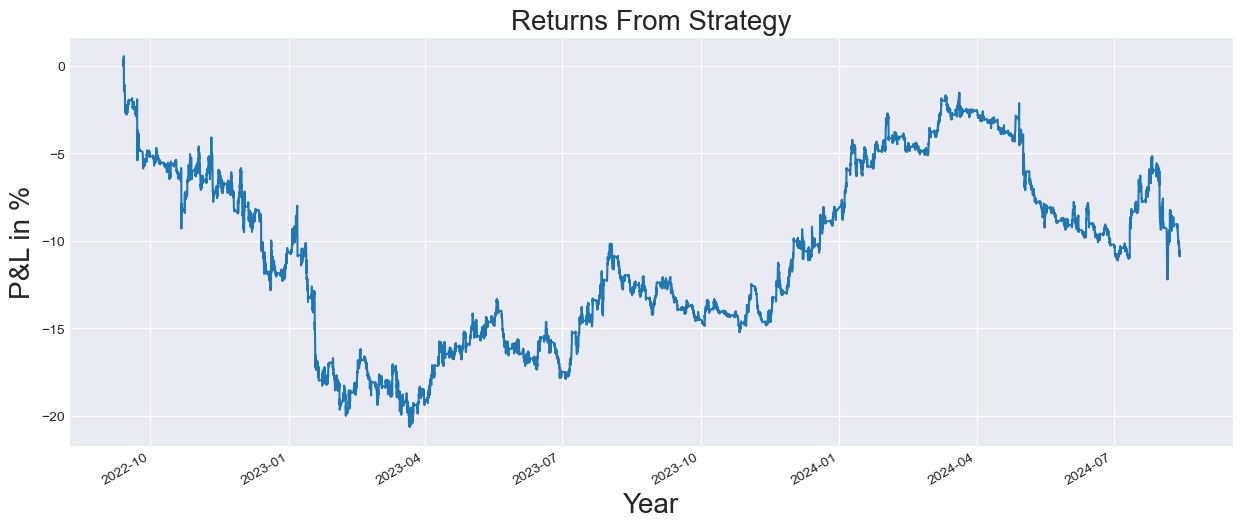

In [24]:
# Plotting the P&l from the Linear Regression Model

(df_with_outcomes["returns"].cumsum()*100).plot(figsize=(15,6))
plt.xlabel('Year', fontsize=20)
plt.ylabel('P&L in %', fontsize=20)
plt.title('Returns From Strategy', fontsize=20)
plt.show()

## Vectorizing the Backtest

**Calculating Sortion Ratio**

The Sortino Ratio tells you how much profit an investment makes compared to the risk of bad returns

- Positive Sortino (> 0): The investment’s returns exceed the target return after accounting for downside risk.
- Negative Sortino (< 0): The investment’s returns are less than the target return when considering downside risk.

In [27]:
# Sortino Ratio is being calculated without a Risk-Free Rate
returns = df_with_outcomes["returns"]
mean_return = np.mean(returns)
downside_deviation = np.std(returns[returns<0])

# Number of 15-minute periods in a year
periods_per_year = 24 * 252

# Annualizing the mean return and downside deviation
annualized_mean_return = mean_return * periods_per_year
annualized_downside_deviation = downside_deviation * np.sqrt(periods_per_year)

# Calculating the annualized Sortino ratio
annualized_sortino = annualized_mean_return / annualized_downside_deviation

print(f"Sortino Ratio: {'%.3f' % annualized_sortino}")

Sortino Ratio: -0.594


**Beta Ratio**

Beta is a measure of the volatility of a security or portfolio in comparison to the overall market, in this particular case I compare it against the SP500

- Beta ≈ 1: The asset moves in line with the market.
- Beta < 1: The asset is less volatile than the market (considered less risky).
- Beta > 1: The asset is more volatile than the market (higher potential return but also higher risk).

In [29]:
# Fetching the oldest date from the X_test set to pull data from the same date for the SP500
date = df_with_outcomes.index.min()

# Extracting the year, month, and day from the date
year = date.year
month = date.month
day = date.day
hour = date.hour
min = date.minute
sec = date.second

date, year, month, day, hour, min, sec

(Timestamp('2022-09-12 23:00:00'), 2022, 9, 12, 23, 0, 0)

In [30]:
# Pulling SP500 data from the specified date and time
sp500_data = data.get_rates(".US500Cash", mt5.TIMEFRAME_H1, from_date=datetime(year, month, day))
sp500_data = sp500_data[["close"]]

# Computing the returns on the SP500 to 
sp500_data["returns"] = sp500_data["close"].pct_change(1)
sp500_data.drop("close", axis=1, inplace=True)
sp500_data.dropna(inplace=True)
sp500_data.head()

,returns
time,
2022-09-12 07:00:00,-0.000221
2022-09-12 08:00:00,0.001623
2022-09-12 09:00:00,0.001055
2022-09-12 10:00:00,0.001152
2022-09-12 11:00:00,0.003160


**Computing Beta Ratio**

In [32]:
# Concatenate values between the returns in the predictions and the returns in the SP500
val = pd.concat((df_with_outcomes["returns"], sp500_data["returns"]), axis=1)

# Changing columns names to indentify each one
val.columns.values[0] = "Returns Pred"
val.columns.values[1] = "Returns SP500"
val.dropna(inplace=True)
val.head()

,Returns Pred,Returns SP500
time,,
2022-09-12 23:00:00,-0.000028,0.000389
2022-09-13 03:00:00,0.000940,0.000413
2022-09-13 04:00:00,0.000695,-0.000607
2022-09-13 05:00:00,-0.001567,0.000729
2022-09-13 06:00:00,0.000505,-0.000534


In [33]:
# Calculating Beta Ratio
covariance_matrix = np.cov(val.values, rowvar=False)
covariance = covariance_matrix[0][1]
variance = covariance_matrix[1][1]
beta = covariance / variance
print(f"Beta Ratio: {'%.3f' % beta}")

Beta Ratio: 0.025


The outcome from Beta Ratio indicates there is a very low correlation between the SP500 and the forecasted returns of the Forex USD JPY pair

**Calculating Alpha Ratio**

Alpha is a measure of how much better or worse an investment performs compared to the overall market, after considering the risk involved
- Positive Alpha (> 0): Indicates the investment outperformed the market.
- Negative Alpha (< 0): Indicates the investment underperformed the market

In [36]:
alpha = (24 * 252 * mean_return * (1-beta))*100
print(f"Alpha Ratio: {'%.3f' % alpha}")

Alpha Ratio: -5.356


## Testing vectorize_backtest_returns Function

**Function added to Backtest File**

In [38]:
backtest.vectorize_backtest_returns(df_with_outcomes["returns"], 24)

Sortino Ratio: -0.594
- Negative Sortino (< 0): The investment’s returns are less than the target return when considering downside risk.

***Asset for Benchamark is S&P500***

Beta Ratio: 0.025
- Beta < 1: The asset is less volatile than the market (considered less risky).

Alpha Ratio: -5.356
- Negative Alpha (< 0): The investment underperformed the market.


# Model Accuracy Analysis

In [40]:
# Creating Dataframe with real positons and predicted positions
df_accuracy = df_with_outcomes[["real_position", "pred_position"]]

# Assigning 1 if the position forecasted is equal to the real position and 0 otherwise
df_accuracy["accuracy"] = np.where(df_accuracy["real_position"] == df_accuracy["pred_position"], 1, 0)
df_accuracy.head()

,real_position,pred_position,accuracy
time,,,
2022-09-12 23:00:00,1.0,-1.0,0
2022-09-13 00:00:00,-1.0,-1.0,1
2022-09-13 01:00:00,-1.0,-1.0,1
2022-09-13 02:00:00,-1.0,-1.0,1
2022-09-13 03:00:00,-1.0,-1.0,1


In [41]:
# Count the occurrences of each unique accuracy value in the 'accuracy' column and store the result in 'accuracy'
accuracy = df_accuracy["accuracy"].value_counts()
accuracy

accuracy
0    6084
1    5851
Name: count, dtype: int64

**Model Accuracy**

In [43]:
# Total counts of occurrences where model was right (number assigned 1) divided into the total number of predictions
model_accuracy = accuracy[1] / len(df_accuracy)
print(f"Model has an accuracy of: {model_accuracy * 100:.2f}%")

Model has an accuracy of: 49.02%


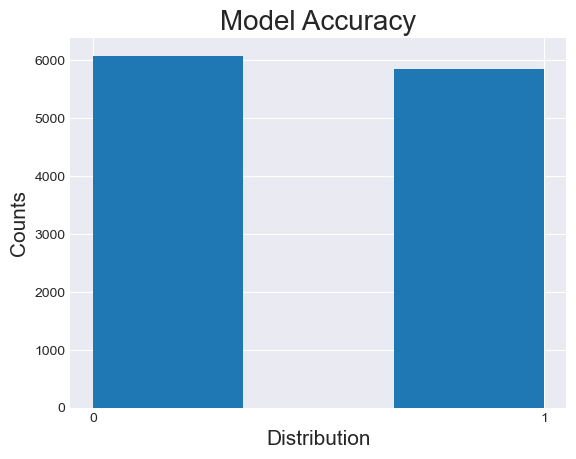

In [44]:
plt.hist(df_accuracy["accuracy"], bins=3)
plt.xticks([0, 1])
plt.title("Model Accuracy", fontsize=20)
plt.ylabel("Counts", fontsize=15)
plt.xlabel("Distribution", fontsize=15);

**Note: A function named (compute_model_accuracy) was added to Backtest File which replicates all previous steps in one go within this Model Accuracy Section**

# Strategy Drawdown Analysis

In [47]:
def strategy_drawdown(return_series):
    """
    Computes and visualizes the drawdown of a strategy based on its return series.

    Parameters:
    return_series (pd.Series): A pandas Series containing the return series of the strategy. 
                               Each value represents the return for a specific period.

    Displays:
    - A plot showing the drawdown over time as a filled area chart.
    - The maximum drawdown percentage is printed to the console.

    Notes:
    - The function assumes the return series is cumulative and starts at zero.
    - NaN values in the return series are dropped before computation.
    - If the return series is empty or contains only NaN values, no plot will be generated.
    """
    
    if return_series.dropna().empty:
        print("The return series is empty or contains only NaN values.")
        return

    # Compute cumulative return
    cumulative_return = return_series.dropna().cumsum() + 1

    # Calculate running maximum
    running_max = np.maximum.accumulate(cumulative_return)

    # Computing the drawdown
    drawdown = cumulative_return / running_max - 1

    plt.figure(figsize=(15, 4))
    plt.fill_between(drawdown.index, drawdown * 100, 0, drawdown, color="red", alpha=0.70)
    plt.title("Strategy Drawdown", fontsize=20)
    plt.ylabel("Drawdown %", fontsize=15)
    plt.show()

    maximum_drawdown = np.min(drawdown) * 100
    print(f"Max Drawdown: {'%.2f' % maximum_drawdown}%")


**This functions was added to Backtest File for reusability** 

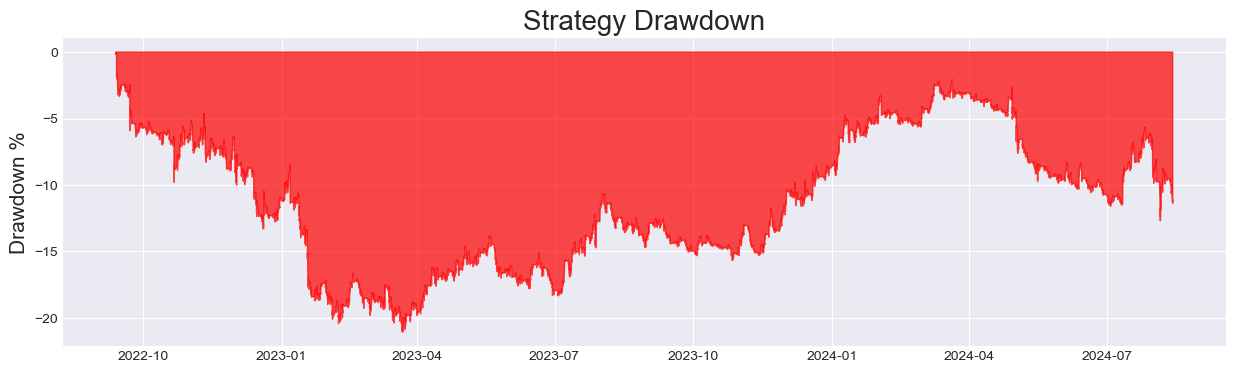

Max Drawdown: -21.08%


In [48]:
strategy_drawdown(df_with_outcomes["returns"])